# Local Row-level Model Temporal Trend Analysis

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Lets load in the raw prediction data for a single model with binning that includes timestamps
# We can use the predictions.parquet file which is used for the R analysis script to generate the plots


In [34]:
path = 'data/exp-43-lstm-local-rounded-cut_100/predictions.parquet'
# Load the data
df = pd.read_parquet(path)
# Check the data
print(df.head())
# Check the columns
print(df.columns)
# Check the shape
print(df.shape)
# Check the dtypes
print(df.dtypes)
# check the info
print(df.info())

   in_lock_sequences_id   in_lock_start_time     in_lock_end_time  \
0                     1  1734442173000567000  1734442173000608000   
1                     1  1734442173000567000  1734442173000608000   
2                     1  1734442173000567000  1734442173000608000   
3                     1  1734442173000567000  1734442173000608000   
4                     2  1734442173000581000  1734442173000612000   

    gt_lock_start_time     gt_lock_end_time model  \
0  1734442173000612000  1734442173000629000  lstm   
1  1734442173000612000  1734442173000629000  lstm   
2  1734442173000612000  1734442173000629000  lstm   
3  1734442173000612000  1734442173000629000  lstm   
4  1734442173000615000  1734442173000655000  lstm   

                            data  train_data_percent_used  epochs  batch_size  \
0  data/fixed/row_sep/ORDERS.csv                      1.0      30          32   
1  data/fixed/row_sep/ORDERS.csv                      1.0      30          32   
2  data/fixed/row_sep/O

In [35]:
# Lets make sure we are sorted by the in_lock_start_time in ascending order
df = df.sort_values(by=['in_lock_start_time'])
df['in_lock_start_time'] = df['in_lock_start_time'] - df['in_lock_start_time'].min()  # center the time around 0

In [36]:
df['in_lock_start_time'].max(), df['in_lock_start_time'].min()

(337999652000, 0)

In [37]:
step_size = 1e10/4
num_plots = 4

Interval 0: 78 unique gt_pageid
Interval 0: 28820 gt_pageid
Interval 0: KL divergence = 0.0010


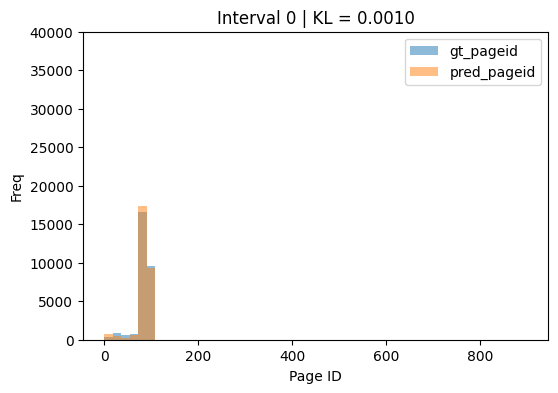

Interval 1: 100 unique gt_pageid
Interval 1: 96490 gt_pageid
Interval 1: KL divergence = 0.0240


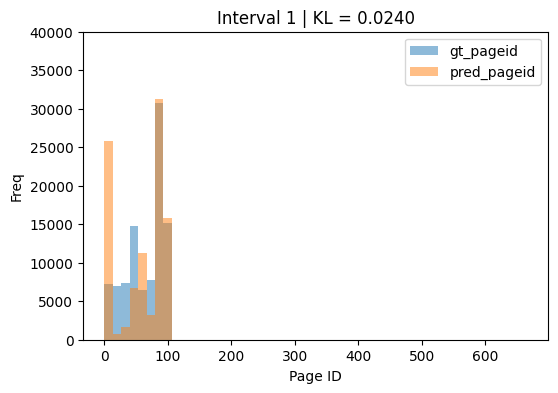

Interval 2: 100 unique gt_pageid
Interval 2: 113940 gt_pageid
Interval 2: KL divergence = 0.0282


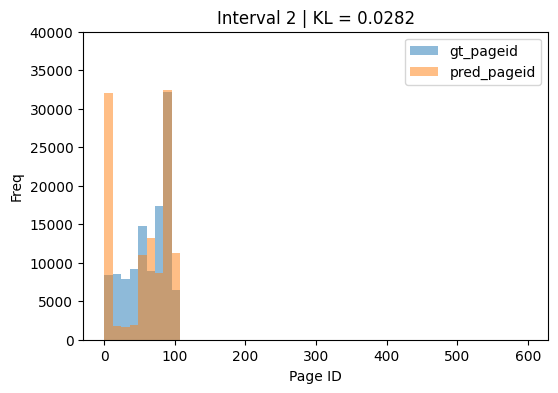

Interval 3: 100 unique gt_pageid
Interval 3: 99140 gt_pageid
Interval 3: KL divergence = 0.0132


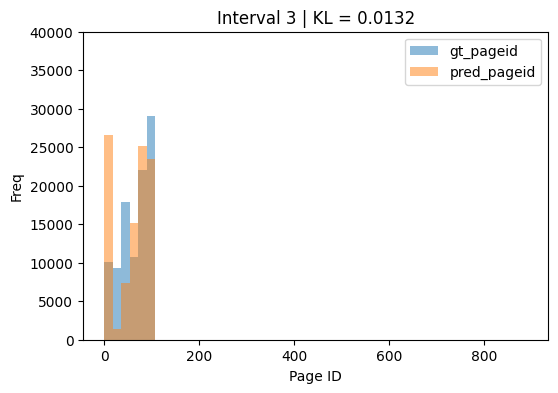

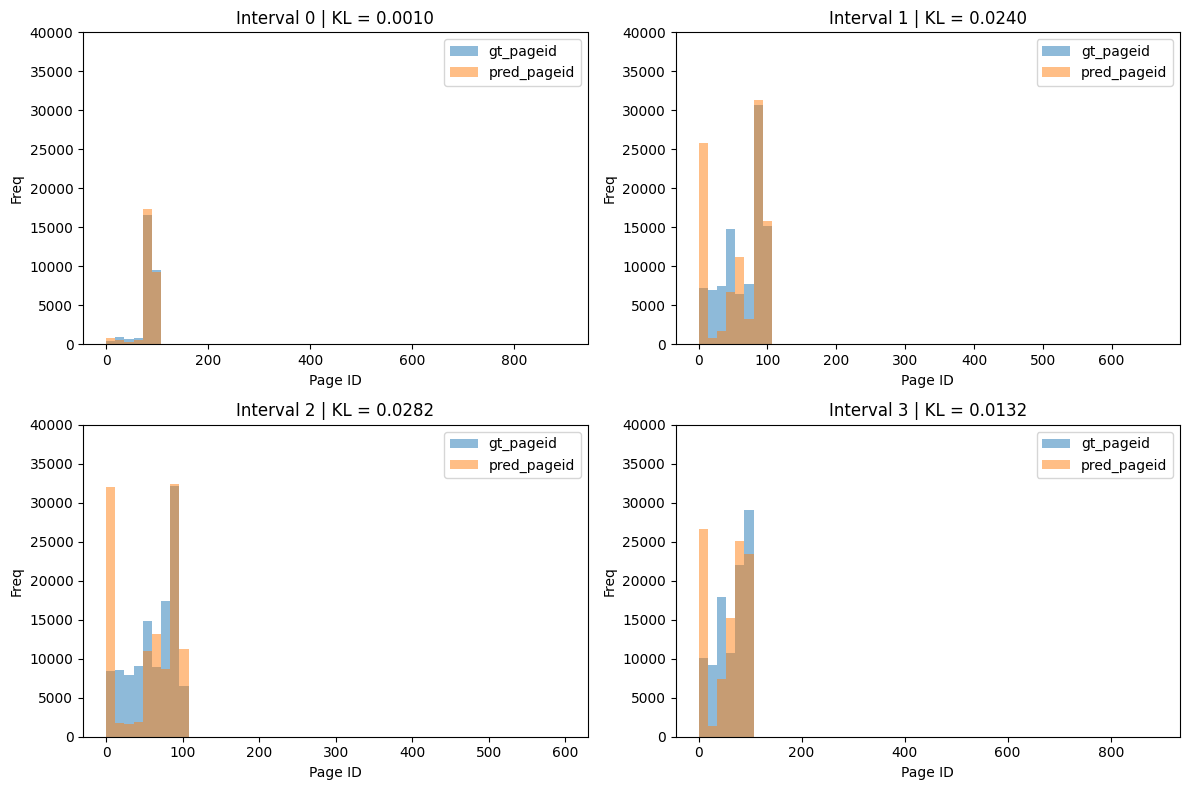

In [51]:
# For storing key info for the final grid
plot_data = []

for i in range(num_plots):
    # Get the start and end time for the interval
    start_time = i * step_size
    end_time = (i + 1) * step_size

    # Get the data for the interval
    df_interval = df[(df['horizon'] == 1) & 
                     (df['in_lock_start_time'] >= start_time) & 
                     (df['in_lock_start_time'] < end_time)]

    print(f'Interval {i}: {df_interval["gt_pageid"].nunique()} unique gt_pageid')
    print(f'Interval {i}: {df_interval["gt_pageid"].count()} gt_pageid')

    # Convert pred_pageid to numeric
    pred_pageid_numeric = pd.to_numeric(df_interval['pred_pageid'], errors='coerce').dropna()

    # Compute bins
    all_pageids = pd.concat([df_interval['gt_pageid'], pred_pageid_numeric])
    bins = np.histogram_bin_edges(all_pageids, bins=50)

    # Compute KL divergence
    epsilon = 1e-10
    gt_hist, _ = np.histogram(df_interval['gt_pageid'], bins=bins, density=True)
    pred_hist, _ = np.histogram(pred_pageid_numeric, bins=bins, density=True)
    gt_hist += epsilon
    pred_hist += epsilon
    kl_div = np.sum(gt_hist * np.log(gt_hist / pred_hist))
    print(f'Interval {i}: KL divergence = {kl_div:.4f}')

    # Plot individually (inline)
    plt.figure(figsize=(6, 4))
    plt.hist(df_interval['gt_pageid'], bins=bins, alpha=0.5, label='gt_pageid')
    plt.hist(pred_pageid_numeric, bins=bins, alpha=0.5, label='pred_pageid')
    plt.title(f'Interval {i} | KL = {kl_div:.4f}')
    plt.xlabel('Page ID')
    plt.ylabel('Freq')
    plt.ylim(0, 40_000)
    plt.legend()
    plt.show()

    # Store for final grid
    plot_data.append((df_interval['gt_pageid'], pred_pageid_numeric, bins, kl_div, i))


# Now plot all together in a grid
ncols = 2
nrows = int(np.ceil(num_plots / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 4))
axs = axs.flatten()

for idx, (gt_pageid, pred_pageid, bins, kl_div, i) in enumerate(plot_data):
    ax = axs[idx]
    ax.hist(gt_pageid, bins=bins, alpha=0.5, label='gt_pageid')
    ax.hist(pred_pageid, bins=bins, alpha=0.5, label='pred_pageid')
    ax.set_title(f'Interval {i} | KL = {kl_div:.4f}')
    ax.set_xlabel('Page ID')
    ax.set_ylabel('Freq')
    ax.set_ylim(0, 40_000)
    ax.legend()

# Remove unused subplots
for j in range(len(plot_data), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
